In [2]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [3]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [4]:
def create_graphs(tcols=[0,2,4,5,6,7,8,10,28], target=8, lim=10.5, save=False, case='test', transform='quantile', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                start=time.time()
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                ##########################################
                ### End loading, begin dtype changing  ###
                ##########################################
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ###################################################
                ### end dtype, begin inital hardcoded scaling   ###
                ###################################################
                
                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]
                #simple log for the rest
                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                del halos
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    for n in scale_cols:
                        n1=np.where(load_cols==n)[0][0]
                        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
                pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

                rhalid=np.array(pdcen[pds.columns[2]])
                del pd0
                del pds
                halwgal=[]
                ids=[]
                out=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        if len(tree)>20000:
                            print(len(tree))
                        else:
                            halwgal.append(tree)
                            ids.append(idx)
                            index=np.where(rhalid==tree[0,1])
                            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
                del pdcen

                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                discards=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                        mask=np.array([bool(i) for i in not_include])
                        idcols=load_cols[~mask] ##choose non-id cols to carry forward
                        mass_id=np.where(np.array(idcols)==10)[0][0]
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                hals=np.array(hals,dtype=object)
                out=np.log10(out) #homemade scaling
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)
                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    if save:
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)
    return dat

In [10]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))
all_cols=np.array([0,2,4,10])
dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')

Loading isotree 0_0_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 9313.38it/s]


Done with tree. 
 Time elapsed 164.10278820991516 s
Loading isotree 0_0_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|████████████████████████████████████████████████████████| 1338/1338 [00:00<00:00, 10117.43it/s]


Done with tree. 
 Time elapsed 449.0104978084564 s
Loading isotree 0_0_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_0_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
72404
60368
26084
29167
Making merger tree


100%|████████████████████████████████████████████████████████| 1472/1472 [00:00<00:00, 10000.62it/s]


Done with tree. 
 Time elapsed 429.5833225250244 s
Loading isotree 0_1_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_1_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70472
Making merger tree


100%|████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 10705.26it/s]


Done with tree. 
 Time elapsed 353.97577834129333 s
Loading isotree 0_1_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_1_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70115
52207
43321
25280
381538
Making merger tree


100%|█████████████████████████████████████████████████████████| 1932/1932 [00:00<00:00, 4404.28it/s]


Done with tree. 
 Time elapsed 561.9882915019989 s
Loading isotree 0_1_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_1_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 605/605 [00:00<00:00, 7958.76it/s]


Done with tree. 
 Time elapsed 82.67065048217773 s
Loading isotree 0_2_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_2_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|█████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 8982.74it/s]


Done with tree. 
 Time elapsed 397.4071958065033 s
Loading isotree 0_2_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_2_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
50415
Making merger tree


100%|█████████████████████████████████████████████████████████| 1286/1286 [00:00<00:00, 8966.06it/s]


Done with tree. 
 Time elapsed 371.8733859062195 s
Loading isotree 0_2_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 0_2_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
43429
Making merger tree


100%|██████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 21925.48it/s]


Done with tree. 
 Time elapsed 162.52765822410583 s
Loading isotree 1_0_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
148608
24297
20509
Making merger tree


100%|█████████████████████████████████████████████████████████| 1810/1810 [00:00<00:00, 6012.13it/s]


Done with tree. 
 Time elapsed 594.5456500053406 s
Loading isotree 1_0_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
48501
36387
36580
Making merger tree


100%|█████████████████████████████████████████████████████████| 1101/1101 [00:00<00:00, 7264.76it/s]


Done with tree. 
 Time elapsed 453.5369462966919 s
Loading isotree 1_0_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_0_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 666/666 [00:00<00:00, 1186.07it/s]


Done with tree. 
 Time elapsed 223.3229682445526 s
Loading isotree 1_1_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_1_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 899/899 [00:00<00:00, 5674.39it/s]


Done with tree. 
 Time elapsed 344.5639798641205 s
Loading isotree 1_1_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_1_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|█████████████████████████████████████████████████████████| 1033/1033 [00:00<00:00, 6060.13it/s]


Done with tree. 
 Time elapsed 459.1768443584442 s
Loading isotree 1_1_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_1_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
51944
Making merger tree


100%|█████████████████████████████████████████████████████████| 1284/1284 [00:00<00:00, 9243.96it/s]


Done with tree. 
 Time elapsed 445.2438859939575 s
Loading isotree 1_2_0


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_2_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 7538.74it/s]


Done with tree. 
 Time elapsed 199.10660696029663 s
Loading isotree 1_2_1


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_2_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|██████████████████████████████████████████████████████████| 509/509 [00:00<00:00, 10691.72it/s]


Done with tree. 
 Time elapsed 98.76652979850769 s
Loading isotree 1_2_2


/tmp/ipykernel_20716/1474294481.py:4: DtypeWarning: Columns (0,1,2,3,4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[2,3,3], lim=10, save=1, case='medium_onlyhmass_smass')


isotree 1_2_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
33451
225562
133989
Making merger tree


100%|████████████████████████████████████████████████████████| 1816/1816 [00:00<00:00, 18563.30it/s]


Done with tree. 
 Time elapsed 358.4219858646393 s
Saving dataset


In [13]:
dat[0].x

tensor([[ 5.1993, -5.1993,  1.0000,  1.2592],
        [ 2.5118,  5.1993,  2.0000,  1.2612],
        [ 2.2900,  2.5755,  2.0000,  1.2838],
        [ 1.7924,  1.8659,  2.0000,  1.3286],
        [ 1.6897,  1.7561,  2.0000,  1.3382],
        [ 1.5418,  1.5932,  2.0000,  1.3610],
        [ 1.5215,  1.5713,  2.0000,  1.3581],
        [ 1.4753,  1.5215,  2.0000,  1.3557],
        [ 1.4533,  1.4980,  2.0000,  1.3532],
        [ 1.4320,  1.4716,  2.0000,  1.3501],
        [ 1.1844,  1.2206,  3.0000,  1.3125],
        [ 1.1571,  1.1921,  2.0000,  1.3100],
        [ 0.7748,  0.7988,  2.0000,  1.2469],
        [ 0.7364,  0.7580,  2.0000,  1.2348],
        [ 0.6943,  0.7152,  3.0000,  1.2232],
        [ 0.3884,  0.4074,  2.0000,  1.1560],
        [ 0.3243,  0.3428,  2.0000,  1.0867],
        [ 0.2536,  0.2731,  2.0000,  1.0545],
        [ 0.0464,  0.0653,  2.0000,  0.9653],
        [-0.4445, -0.4266,  3.0000,  0.8904],
        [-0.5643, -0.5467,  2.0000,  0.8600],
        [-0.7547, -0.7348,  2.0000

In [24]:
xs=[]
ls=[]
ks=[]
mh=[]
for d in dat:
    xs.append(d.x.numpy())
    ls.append(len(d.x.numpy()))
    ks.append(1/np.array(d.edge_attr))
    mh.append(d.x.numpy()[0,3])
xs=np.vstack(xs)
ks=np.hstack(ks)

array([ 3.        , 27.99999809])

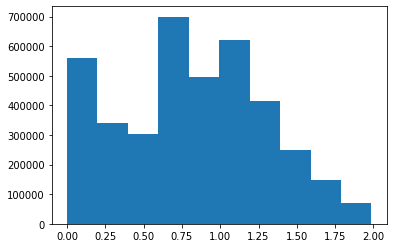

In [15]:
plt.hist(np.log10(ks))
np.quantile(ks, [0.25,0.9])

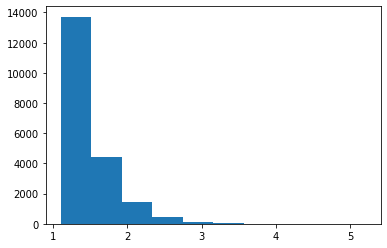

In [26]:
plt.hist(mh);

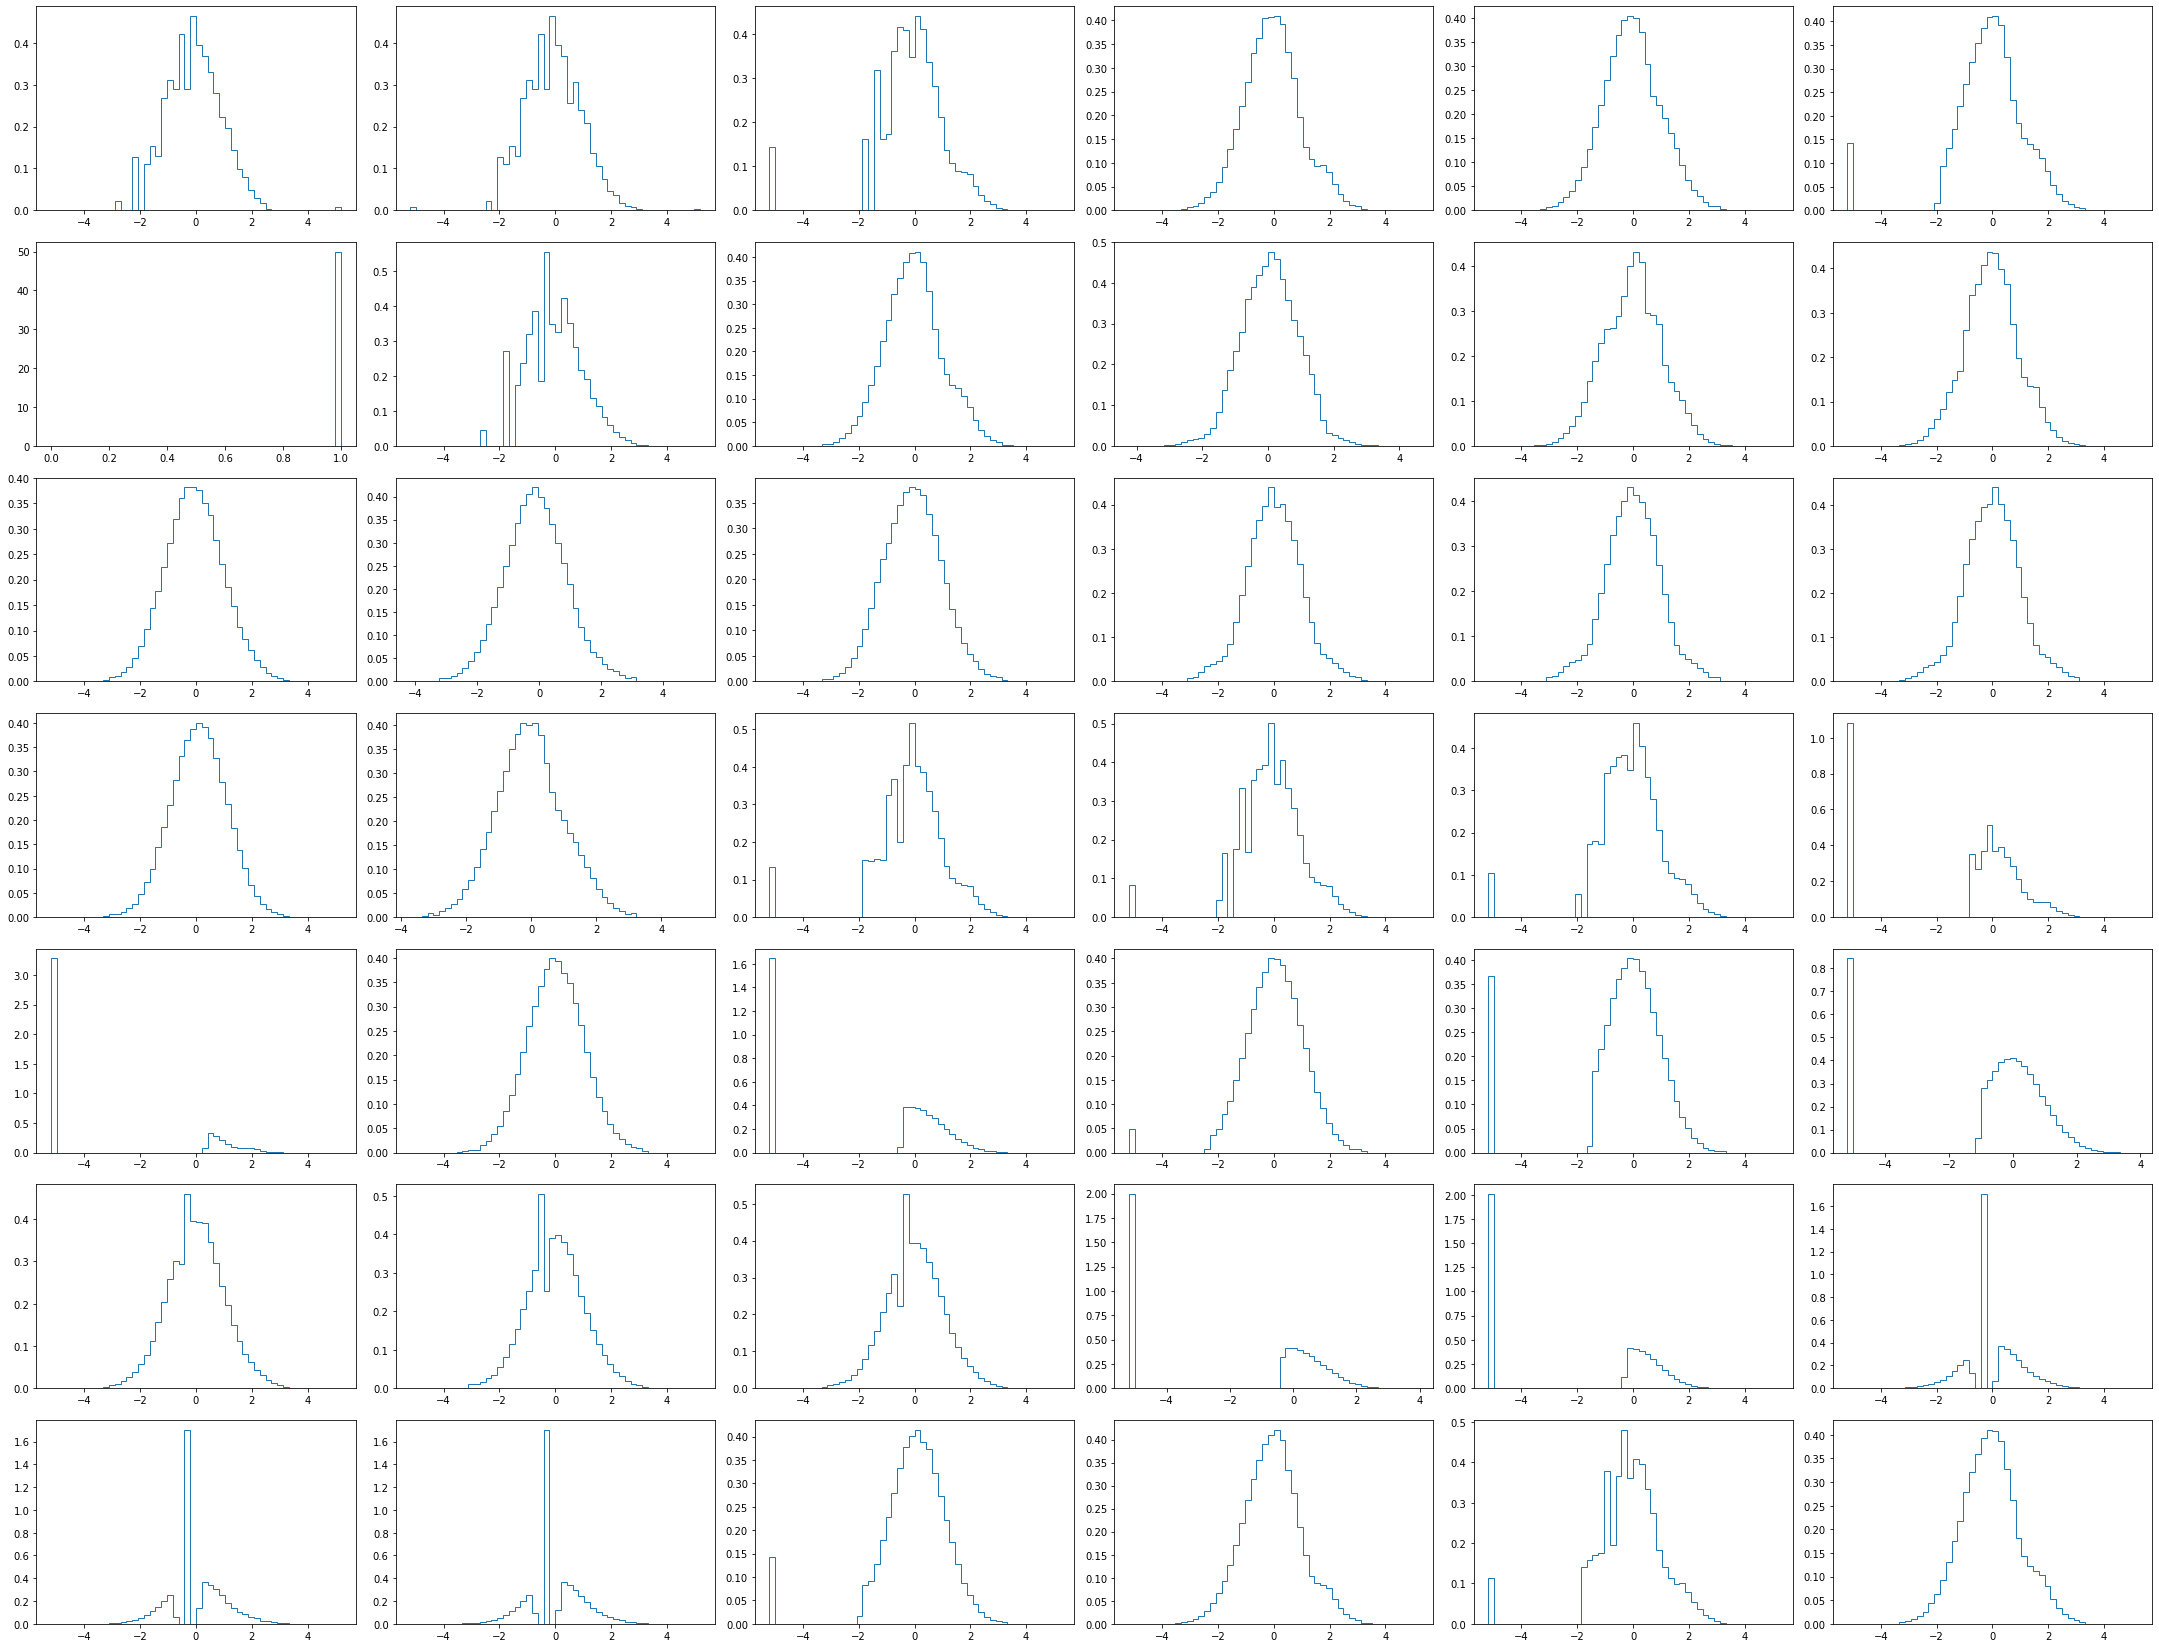

In [15]:
fig,ax=plt.subplots(nrows=7,ncols=6, figsize=(30,23))
ax=ax.flatten()
for i in range(len(xs[0])):
    ax[i].hist(xs[:,i], bins=50, density=1, histtype='step');
#     ax[i].set(title=halos.columns[np.array(fcols)+1][i])
# plt.hist(a[:,n], bins=100, density=1);
fig.tight_layout()

In [80]:
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])
len(castto)

25

In [50]:
load_cols=np.array([0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
f,it="float64", "int64"
maps=[]
for m in load_cols:
    if m<=26:
        maps.append(m)
maps=np.array(maps)
castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])

In [24]:
load_cols

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 35, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [16]:
maps, len(castto), castto[maps], castto

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 26,
 array(['float64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64',
        'int64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'int64', 'float64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'float64', 'float64', 'float64', 'float64', 'float64'],
       dtype='<U7'),
 array(['float64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64',
        'int64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'int64', 'float64', 'float64', 'float64', 'float64',
        'float64', 'float64', 'float64', 'float64', 'float64', 'float64',
        'float64'], dtype='<U7'))

In [20]:
halos

,index,#scale(0),id(1),desc_scale(2),desc_id(3),num_prog(4),pid(5),upid(6),desc_pid(7),phantom(8),...,A[z],b_to_a(500c),c_to_a(500c),A[x](500c),A[y](500c),A[z](500c),T/|U|,M_pe_Behroozi,M_pe_Diemer,Halfmass_Radius
1,51,1.00000,1122969403,0.00000,-1,1,-1,-1,-1,0,...,-0.59764,0.73477,0.30184,1.11307,-1.04583,-0.49679,0.6532,187100000.0,42000000.0,2.103
2,52,0.99057,1113370505,1.00000,1122969403,1,-1,-1,-1,0,...,-0.80679,0.63215,0.15637,0.72804,-0.80641,-0.81522,0.8323,248100000.0,48000000.0,1.678
3,53,0.97659,1103578712,0.99057,1113370505,1,-1,-1,-1,0,...,0.82788,0.80679,0.18344,-0.68020,1.36609,1.06240,0.7812,166800000.0,30000000.0,2.681
4,54,0.96738,1093866277,0.97659,1103578712,1,-1,-1,-1,0,...,1.62453,0.19157,0.13979,-0.71347,0.31104,1.71859,0.9205,183100000.0,36000000.0,2.670
5,55,0.95372,1084166184,0.96738,1093866277,1,-1,-1,-1,0,...,1.72263,0.53219,0.33932,-0.44511,0.40864,1.70194,0.5444,186600000.0,30000000.0,2.603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884349,4884399,0.62557,754249688,0.63453,765435978.0,1.0,-1.0,-1.0,-1.0,0.0,...,2.13641,0.75990,0.45814,0.80072,0.69614,2.14372,0.5525,154000000.0,6000000.0,3.489
4884350,4884400,0.61674,742999164,0.62557,754249688.0,1.0,-1.0,-1.0,-1.0,0.0,...,1.74596,0.55970,0.36708,1.11629,0.99403,1.74596,0.6376,177200000.0,30000000.0,2.730
4884351,4884401,0.60804,731685427,0.61674,742999164.0,1.0,-1.0,-1.0,-1.0,0.0,...,1.19227,0.47104,0.30776,1.14373,0.99976,1.19227,0.8559,201800000.0,48000000.0,1.864
4884352,4884402,0.59662,720303756,0.60804,731685427.0,1.0,-1.0,-1.0,-1.0,0.0,...,0.48832,0.58741,0.35526,0.65286,1.69596,0.35190,0.7588,205000000.0,42000000.0,2.343


In [48]:
mask=halos.dtypes.values[1:]=='O'
top=max(np.array(load_cols)[mask])+1
print(top)
f,it="float64", "int64"
maps=[]
for l in load_cols:
    if l<=25:
        maps.append(l)
maps=np.array(maps)
castto1=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f])
castto=castto1[maps]
dicts = {}
keys = halos.columns[1:top]
for d, key in enumerate(keys):
            print(key, castto[d])
#         dicts[key] = castto[d]
# halos=halos.astype(dicts)

25
#scale(0) float64
id(1) int64
desc_scale(2) float64
desc_id(3) int64
num_prog(4) int64
pid(5) int64
upid(6) int64
desc_pid(7) int64
phantom(8) int64
Mvir(10) float64
Rvir(11) float64
rs(12) float64
vrms(13) float64
mmp?(14) int64
scale_of_last_MM(15) float64
vmax(16) float64
x(17) float64
y(18) float64
z(19) float64
vx(20) float64
vy(21) float64
vz(22) float64
Jx(23) float64
Jy(24) float64


In [99]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,24,25,35]+list(range(37,60)))

target=8
lim=11
case='test'
transform='quantile'
maxs=[1,1,1]
dat=[]
tcols=np.array(all_cols)
raw_path='../../../../tigress/mcranmer/merger_trees/isotrees/'
target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
transform_path=f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]
start=time.time()
for i in range(0, maxs[0]):
    for j in range(0,maxs[1]):
        for k in range(0, maxs[2]):
            print(f'Loading isotree {i}_{j}_{k}')
            pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
            print(f'isotree {i}_{j}_{k} loaded, restructuring')

            raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
            del pd1

            trees=raw[raw.isna()['desc_id(3)']] 
            halos=raw[~raw.isna()['desc_id(3)']]
            del raw
 



Loading isotree 0_0_0
isotree 0_0_0 loaded, restructuring


In [104]:
mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
k=0
for l in load_cols:
    k+=1
    if l<25:
        map1.append(l)
        map2.append(k)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

25 [ 0  1  2  3  4  6  7  8 10 11 12 13 14 15 16 17 18 19 22 23 24] 21


{'#scale(0)': 'float64',
 'id(1)': 'int64',
 'desc_scale(2)': 'float64',
 'desc_id(3)': 'int64',
 'num_prog(4)': 'int64',
 'upid(6)': 'int64',
 'desc_pid(7)': 'int64',
 'phantom(8)': 'int64',
 'Mvir(10)': 'float64',
 'Rvir(11)': 'float64',
 'rs(12)': 'float64',
 'vrms(13)': 'float64',
 'mmp?(14)': 'int64',
 'scale_of_last_MM(15)': 'float64',
 'vmax(16)': 'float64',
 'x(17)': 'float64',
 'y(18)': 'float64',
 'z(19)': 'float64',
 'vz(22)': 'float64',
 'Jx(23)': 'float64',
 'Jy(24)': 'float64'}

In [87]:
tcols=[0,2,4,5,6,7,8,10,41]
target=8
lim=10
save=0
case='test'
transform='quantile'
maxs=[1,1,1]
i,j,k=1,1,2
dat=[]
tcols=np.array(tcols)
raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) 
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3])
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]


start=time.time()
print(f'Loading isotree {i}_{j}_{k}')
pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
print(f'isotree {i}_{j}_{k} loaded, restructuring')

raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
del pd1

trees=raw[raw.isna()['desc_id(3)']] 
halos=raw[~raw.isna()['desc_id(3)']]
del raw

##########################################
### End loading, begin dtype changing  ###
##########################################

mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
q=0
for l in load_cols:
    q+=1
    if l<25:
        map1.append(l)
        map2.append(q)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

###################################################
### end dtype, begin inital hardcoded scaling   ###
###################################################

## initial scaling
hard=[0,2,15]
def logit(x):
    return np.log10((x+0.001)/(1.01-x))
##logit transform the hards
for h in hard:
    if h in tcols:
        h1=np.where(load_cols==h)[0][0]+1
        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

log=[10,38, 39, 40, 41, 42]
#simple log for the rest
def logt(x):
    return np.log10(x+1)
for l in log:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

scale_cols=np.array(tcols[~is_cat[tcols]])

print(f'Splitting to tree and scaling')
spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
del halos
splits=[]
for s in spli:
    if s[0,np.where(load_cols==10)[0][0]]>lim:
        splits.append(s)
splits=np.array(splits, dtype=object)
split=[]
for tree in splits:
    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
    for n in scale_cols:
        n1=np.where(load_cols==n)[0][0]
        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
    split.append(s)
split=np.array(split, dtype=object)
print('Split done')
print('Loading targets')
ex=f'{i}_{j}_{k}/galprop_0-99.dat'
pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
newcols=pdc.iloc[:,0]
pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
pds.columns=np.array(newcols)
pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

rhalid=np.array(pdcen[pds.columns[2]])
del pd0
del pds
halwgal=[]
ids=[]
out=[]
for idx, tree in enumerate(split): #split up into tree
    if tree[0,1] in rhalid:
        if len(tree)>20000:
            print(len(tree))
        else:
            halwgal.append(tree)
            ids.append(idx)
            index=np.where(rhalid==tree[0,1])
            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
del pdcen

hraw=np.array(splits[ids], dtype=object)
hals=[]
pr,de=[],[]
discards=[]
print('Making merger tree')
for n in tqdm(range(len(halwgal))):
    h=halwgal[n]
    roots=h[h[:,4]==0]
    mergers=h[h[:,4]>1]
    final=h[h[:,3]==-1]
    pro, des=[],[]
    discarded=[]
    for mid in mergers[:,1]:
        k=1
        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
        while descid not in mergers[:,1] and descid!=-1: 
            k+=1
    
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
        pro.append(mid)
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
        discarded.append(1/k) 

    for r in roots:
        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
        k=1
        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
            k+=1
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
        pro.append(r[1])
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
        discarded.append(1/k) 

    discards.append(np.array(discarded))
    des,pro=convert(des, pro)
    hal2=np.vstack([final,mergers,roots])
    global mass_index
    if n==0:
        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
        mask=np.array([bool(i) for i in not_include])
        idcols=load_cols[~mask] ##choose non-id cols to carry forward
        mass_id=np.where(np.array(idcols)==10)[0][0]
    hal2=hal2[:,fcols] ##take away id's
    hals.append(hal2)
    pr.append([int(p) for p in pro])
    de.append([int(d) for d in des])
hals=np.array(hals,dtype=object)
out=np.log10(out) #homemade scaling
for n in tqdm(range(len(out))):
    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
    x = torch.tensor(hals[n], dtype=torch.float)
    y=torch.tensor(out[n], dtype=torch.float)
    edge_attr=torch.tensor(discards[n], dtype=torch.float)
    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dat.append(graph)
stop=time.time()
print(f'Done with tree. \n Time elapsed {stop-start} s')
if save:
    print("Saving dataset")
    if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
        os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

    with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
        pickle.dump(dat, handle)

Loading isotree 1_1_2


/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


isotree 1_1_2 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
51944
Making merger tree


100%|████████████████████████████████████████████████████████| 1284/1284 [00:00<00:00, 12151.34it/s]

Done with tree. 
 Time elapsed 230.82173538208008 s


In [93]:
ls=[]
for d in dat:
    ls.append(len(d.x))

AttributeError: 'GlobalStorage' object has no attribute 'num_nodes'

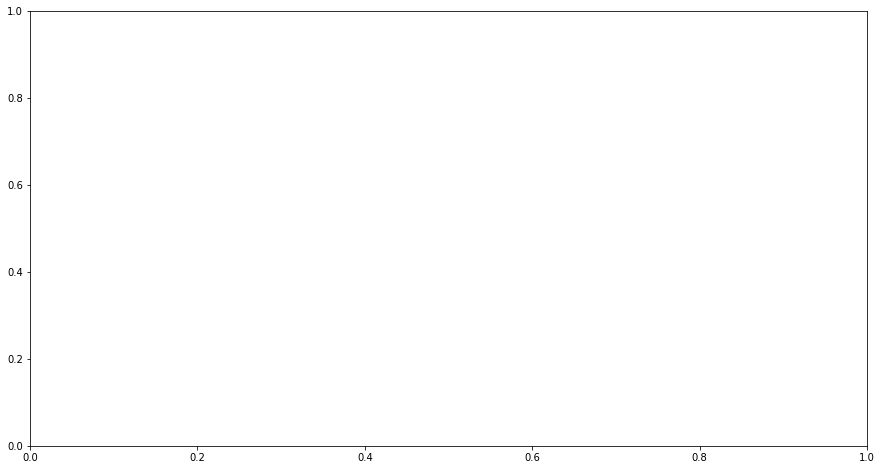

In [8]:
#graph 275

j=12
from matplotlib import cm
cmap=cm.get_cmap(name='magma')
fig,ax=plt.subplots(figsize=(15,8))
G=tg.utils.to_networkx(dat[j])
di=nx.betweenness_centrality(G)
for q,key in enumerate(di.keys()):
    di[key]=dat[j].x.numpy()[q,2]
nx.set_node_attributes(G, di, 'n_prog')
print('Made graph')
# G.remove_nodes_from(list(nx.isolates(G)))
pos=nx.planar_layout(G)
# pos=nx.kamada_kawai_layout(G) #this one is kinda snakey but works pretty well! Slow as hell though
if G.number_of_nodes()<2000:
    print('drawing')
    nx.draw(G, pos=pos,ax=ax, node_size=8, arrowsize=5, cmap=cmap)

In [ ]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
fig,ax=plt.subplots(figsize=(25,12))
# get unique groups
groups = set(nx.get_node_attributes(G,'n_prog').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors=dat[j].x.numpy()[:,2]
sizes=(dat[j].x.numpy()[:,3]-min(dat[j].x.numpy()[:,3])+1)**2
# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.planar_layout(G)
ec = nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodes, node_color=colors, node_size=sizes, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [101]:
dat[12].x

tensor([[ 5.1993, -5.1993,  7.0000,  2.3397,  2.3519],
        [ 5.1993, -5.1993,  7.0000,  2.3397,  2.3519],
        [ 2.5118,  5.1993, 10.0000,  2.3391,  2.3488],
        ...,
        [ 1.3814,  1.4216,  0.0000, -0.1524, -0.1207],
        [ 2.1969,  2.4086,  0.0000,  0.0741,  0.1499],
        [ 2.2900,  2.5755,  0.0000, -0.5865, -5.1993]])

In [90]:
dat[1]

Data(x=[64, 5], edge_index=[2, 63], edge_attr=[63], y=-0.7890210151672363)

In [66]:
dis=[]
descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
k=1
while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
    k+=1
    descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
    print(descid)
dis.append(1/k)

[62310517.]
[73469508.]
[84968192.]


In [71]:
hraw[n][:,3][np.where(mid==hraw[n][:,1])][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [74]:
np.where(r[1]==hraw[n][:,1]), mid

((array([18]),), 71669478.0)

In [77]:
(hraw[n][:,1][np.where(-1==hraw[n][:,3])][0])

1123772897.0